+ title: Fine-tune a German GPT-2 Model with Tensorflow in Transformers for text generation (NLP part 4)
+ date: 2021-03-19
+ tags: python, NLP, text generation, GPT-2, tensorflow, transformers, transfer learning
+ Slug: finetune-german-gpt2-on-tpu-transformers-tensorflow-for-text-generation-of-reviews
+ Category: Python
+ Authors: MC
+ Summary: We build a model that can be prompted to generate human like positive and negative medical reviews in German. For that, we fine-tune GPT-2 on an unique data set using Tensorflow in Transformers. For fast results, we use TPUs on Google Colab. 

## Motivation 

This is part four of our NLP series. In this series, we use a unique data set of German reviews of physicians written by their patients. So far, we've explored several methods for doing sentiment analysis / binary text classification. (Check out: [part 1]({filename}/doctors_nlp1.ipynb), [part 2]({filename}/doctors_nlp2.ipynb) and [part 3]({filename}/doctors_nlp3.ipynb))  
Here, we move to an exciting new area: text generation with neural networks. Because our data set is not only extensive but also of high quality, it lends itself perfectly for training a neural network. As before, we make use of the power of transfer learning: We use a model that has been pre trained on German texts and fine-tune it using our review data. One of the currently available, best models for this task is GPT-2. It achieves amazing results in writing human like texts. A [German version of GPT-2](https://huggingface.co/dbmdz/german-gpt2) has been recently (Nov. 2020) released for the transformers library. Shout out to the [Bavarian State Library](https://github.com/dbmdz) for publishing it!  
So far, there are few learning resources dealing with this model. A notable exception is this [blog post](https://www.philschmid.de/fine-tune-a-non-english-gpt-2-model-with-huggingface) by Philipp Schmid. It shows how to use the model in transformers using PyTorch for creating novel recipes.  
We add to this in several ways and also approach things a bit differently:
 * We use an extensive data set comprised of >400k German medical text reviews to fine-tune the model using the transformers library
 * We use the Tensorflow instead of PyTorch implementation and deal with some undocumented quirks
 * Using TPUs on Google Colab we reduce training time to a reasonable amount
 * Our data set has text comments and their corresponding rating. Hence, we're able to teach our model to generate positive and negative reviews, as requested
 
You can download this notebook or follow along in an free interactive version of it on Google Colab: <a href="https://colab.research.google.com/github/mc51/blog_posts/blob/master/doctors_nlp4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="display:inline;"/></a>.

### Setup / Data set / cleaning / pre processing

As this is not the focus of this post, we will go through these steps rather quickly. If you need a refresher on cleaning and pre processing, check out the [first]({filename}/doctors_nlp1.ipynb) and [second post]({filename}/doctors_nlp2.ipynb) again. 

We'll be using an updated version of the data that is more recent and contains even more reviews compared to the previous posts. You can take a look at it on [data.world](https://data.world/mc51/german-language-reviews-of-doctors-by-patients-2021) or directly download it from [here](https://query.data.world/s/wssnwo4qomcjbketegzxtort7pnaxk).  
We will need to use a [TPU](https://cloud.google.com/tpu/docs/colabs) because of the high computational demand of GPT-2 and the size of the data. While you can get away with using GPUs as well, you won't stand any chance to run this on a CPU. Luckily, the notebooks on Google Colab offer free TPU usage. If you want to replicate this post, your best bet is to start there.  
Now, let's get rolling:

In [2]:
import os

# Do this only Google Colab
if os.environ.get("COLAB_GPU", False):
    !pip install -U datasets transformers
    from google.colab import drive

    drive.mount("/drive")

import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)

PATH_BASE = "/drive/My Drive"

Mounted at /drive
2.4.1
4.4.2


In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.92.53.250:8470']
REPLICAS:  8


We are running on 8 TPUs. For free. Thanks Google! Next, let's download the data and take a first look at it:

In [ ]:
# Download and extract data
!wget -O 2021_reviews.zip https://query.data.world/s/wssnwo4qomcjbketegzxtort7pnaxk
!unzip 2021_reviews.zip

In [ ]:
# read data
reviews = pd.read_csv("2021_german_doctor_reviews.csv")
# mark bad ratings
reviews["bad_rating"] = np.where(
    reviews["rating"] > 3, "<|review_neg|>", "<|review_pos|>"
)
reviews.head(3)

,rating,comment,bad_rating
0,2.0,"Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!",<|review_pos|>
1,6.0,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist,er ist unfreundlich ,sehr herablassend und medizinisch unkompetent.Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half.Meine Beschweerden hatten einen völlig anderen Grund.<br />\nNach seiner "" Behandlung "" und Diagnose ,waren seine letzten Worte .....und tschüss.Alles inerhalb von ca 5 Minuten.",<|review_neg|>
2,1.0,Hatte akute Beschwerden am Rücken. Herr Magura war der erste Arzt der sich wirklich Zeit für einen Therapieplan genommen hat um nachhaltig meine Schmerzen zu beseitigen,<|review_pos|>


Here's an important first trick we use. As we have the review's comment and rating (1 best, 6 worst), we are able to classify negative and positive comments. In the previous posts, we've use this to create a classification model. This time, we will use this to teach our model to generate positive as well as negative reviews. For that, we create the special tokens `<|review_neg|>` and `<|review_pos|>` according to the rating. These will allow GPT-2 to learn the differences between good and bad reviews during training. Here's quick glimpse at the composition of our reviews:

In [ ]:
reviews["bad_rating"].value_counts()

<|review_pos|>    390134
<|review_neg|>     49109
Name: bad_rating, dtype: int64

In total we have 439243 reviews. Most of them are positive, but still we have more than 49k negative ones as well.  
Following, we pre process the comments. We do so by removing irregular characters from the text and making sure we use consistent spacing:

In [ ]:
%%time
def clean_text(text):
    """
    - remove any html tags (< /br> often found)
    - Keep only ASCII + Latin chars, digits and whitespaces
    - pad punctuation chars with whitespace
    - convert all whitespaces (tabs etc.) to single wspace
    """
    RE_PUNCTUATION = re.compile("([!?.,;-])")
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!?0-9 ]", re.IGNORECASE)
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_PUNCTUATION, r" \1 ", text)
    text = re.sub(RE_WSPACE, " ", text)
    return text


# Clean Comments. Only keep long enough
reviews["comment_clean"] = reviews.loc[reviews["comment"].str.len() > 10, "comment"]
reviews["comment_clean"] = reviews["comment_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

CPU times: user 23.4 s, sys: 173 ms, total: 23.6 s
Wall time: 23.7 s


In [ ]:
# Drop Missing and save to file
reviews = reviews.dropna(axis="index", subset=["comment_clean"]).reset_index(drop=True)
# add rating indicator as first word of comment
reviews["comment_clean"] = reviews["bad_rating"] + " " + reviews["comment_clean"]
data = reviews[["comment_clean"]]
data.columns = ["text"]
# data.to_csv(PATH_BASE + "/data/reviews_clean_rating.csv", index=False)
data.head(2)

,text
0,"<|review_pos|> Ich bin franzose und bin seit ein paar Wochen in muenchen . Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen . Ich habe schnell ein Termin bekommen , das Team war nett und meine schmerzen sind weg ! ! Ich bin als Angst Patient sehr zurieden ! !"
1,"<|review_neg|> Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist , er ist unfreundlich , sehr herablassend und medizinisch unkompetent . Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half . Meine Beschweerden hatten einen völlig anderen Grund . Nach seiner Behandlung und Diagnose , waren seine letzten Worte . . . . . und tschüss . Alles inerhalb von ca 5 Minuten ."


That'll be the foundation for creating the input to our GPT-2 model. We didn't have to do too much with our text.

### Create Model Inputs
Following, we use the [datasets](https://huggingface.co/docs/datasets/) library to convert the pandas dataframe to a `Dataset` object. This object has some helpful properties when working with the transformers library:

In [26]:
# Read data from file and load as dataset
data = pd.read_csv(PATH_BASE + "/data/reviews_clean_rating.csv")
data = Dataset.from_pandas(data)
data

Dataset({
    features: ['text'],
    num_rows: 439243
})

We use the pre trained tokenizer for German that comes with the model. As we've introduced tokens for negative and positive reviews, we add them to the tokenizer's vocabulary using `add_tokens`. We also add a new token for padding:

In [ ]:
MAX_TOKENS = 128
POS_TOKEN = "<|review_pos|>"
NEG_TOKEN = "<|review_neg|>"
BOS_TOKENS = [NEG_TOKEN, POS_TOKEN]
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"

# this will download and initialize the pre trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "dbmdz/german-gpt2",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)
tokenizer.add_tokens(BOS_TOKENS, special_tokens=True)

Coming up, we prepare the model input. For that, we have to do several tasks:
1. We add our end of sentence (eos) token, `<|endoftext|>` at the end of each comment
2. We tokenize each comment using the pre trained German [GPT-2 tokenizer](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2tokenizerfast) we've initialized before
3. While doing so, we add padding (using `<|pad|>` as a token) / or truncate each comment so that is has exactly `MAX_TOKENS` tokens
4. The tokenizer then also takes care of converting the tokens to a numeric representation `input_ids` (each token corresponds to a specific numeric id)
5. Next, we need to create `labels` as an input as well. These are actually the same as the shifted `input_ids`, but we replace ids corresponding to our padding token with `-100`
6. Finally, the tokenizer also creates the `attention_mask`. This is just a vector consisting of `1` for all relevant elements in `input_ids` and `0` for all padding tokens  

I'll explain a bite more in the following. But first, here's the corresponding code:

In [ ]:
%%time

output = {}
# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["text"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


data = data.map(
    tokenize_function,
    batched=True,
    num_proc=strategy.num_replicas_in_sync,
    remove_columns=["text"],
    load_from_cache_file=True,
)
print(data)

The `map` method applies `tokenize_function` to our data set. By default, `batched=True` applies the function to a batch of 10k rows and using `num_proc` we can do this in parallel. We use a `MAX_TOKENS` value of 128. This covers about 80% of all reviews in our data set without truncation. Increasing this is costly in terms of additional computation time, so this is a good compromise.  
We need to talk a bit more about what we're doing after we've applied `tokenizer` to our batches. This is because those quirks are currently **not properly documented** and **they differ in the Tensorflow transformers implementation of GPT-2** compared to the PyTorch version. In particular, the shifting of `input_ids` and `labels` happens inside the model during training when using the PyTorch model but not in the Tensorflow version. Thus, we need to explicitly do it beforehand. But why do we need the shifting at all? Well, we train GPT-2 on the task of causal language modeling. Basically, given a sequence of words the model learns to guess the next word. However, the model uses ids not words. So, given a sequence of `input_ids` what will be the next `input_id`? For computing the loss on this task, the model compares its predicted output with a label. Hence, `labels` must be the shifted `input_ids`.  
Moreover, we don't want the model to train on or predict padding tokens. This is where the [attention mask](https://huggingface.co/transformers/glossary.html#attention-mask) comes into play. But this must be also be taken into account during loss computation. The transformer implementation of GPT-2 does this internally by ignoring all labels that are `-100`. Hence, we adapt our `labels` accordingly.  
*Notice*: Currently this behavior is documented for the [PyTorch implementation](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel) but not for the [Tensorflow one](https://huggingface.co/transformers/model_doc/gpt2.html#tfgpt2lmheadmodel).    
Now, we're almost done preparing our data. We just need to create a split for training and testing and convert the data to the appropriate format for Tensorflow before we can start building our model: 

In [5]:
# Load Inputs and create test and train split
# data.save_to_disk(PATH_BASE + "/data/reviews_tokenized_128_ratings")
data = datasets.load_from_disk(PATH_BASE + "/data/reviews_tokenized_128_ratings")
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.20, shuffle=True, seed=1, load_from_cache_file=True
)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 351394
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 87849
    })
})


In [6]:
%%time
# prepare for use in tensorflow
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

CPU times: user 2min 23s, sys: 12.8 s, total: 2min 35s
Wall time: 2min 36s


This concludes the data preparation.

### Build and train GPT-2 Model

Next, we can start defining our model architecture:

In [15]:
# Model params
BATCH_SIZE_PER_REPLICA = 28
EPOCHS = 6
INITAL_LEARNING_RATE = 0.001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

# prepare data for consumption
train_ds = (
    train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
)
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

The maximal batch size we can use on Colab in this case is about 28 per TPU. In total that will sum to 224. We set an initial learning rate that is probably higher than what is usually used for fine tuning. However, we will use a learning rate scheduler that decreases this rate rather quickly in the next step. This is by no means a well tested strategy, so feel free to play around with the learning rate yourself! The same goes for the number of epochs, which we keep on the lower side here to decrease training time.  
Following, we set up our model from the pre trained version.  
*Please note:* There is a [(TF)Trainer](https://huggingface.co/transformers/main_classes/trainer.html) class in transformers which provides a feature complete and simple training API. However, the Tensorflow implementation (`TFTrainer`) [does not currently work on TPUs](https://github.com/huggingface/transformers/issues/6672). Hence, we use the "traditional" way of defining and training our model.

In [14]:
# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)

# initialize model, use_cache=False important! else wrong shape at loss calc
with strategy.scope():
    model = TFGPT2LMHeadModel.from_pretrained(
        "dbmdz/german-gpt2",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model.resize_token_embeddings(len(tokenizer))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=model.compute_loss)
    model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at dbmdz/german-gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  125781504 
Total params: 125,781,504
Trainable params: 125,781,504
Non-trainable params: 0
_________________________________________________________________


Again, there are some pitfalls here. Most important, training will fail when we don't set `use_cache=False`! Also, we need to let the model know about the padding and eos tokens we are using. Moreover, we've added some tokens in addition to the ones that were included in the pre trained tokenizer and used to train the pre trained model. Consequently, we need to adapt the model to deal with that. We do this with the `resize_token_embeddings` method. Finally, the GPT-2 model implementation uses a custom function for computing the loss (for example it ignores labels containing -100, as mentioned before). So, instead of using one of the regular loss functions, we need to refer to the model's own `compute_loss` method.  
Before we start training, let's define some callbacks that will be used during training:

In [16]:
# Stop training when validation acc starts dropping
# Save checkpoint of model after each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        PATH_BASE + "/data/models/" + now + "_GPT2-Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

We will stop model training prematurely, if the the validation loss does not improve after an epoch. Also, we make sure to save model checkpoints after each epoch so that we can resume training later on.  
Now, we're all set for training. Let's start fine-tuning our model:

In [17]:
%%time
# Train Model
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Model Params:
batch_size: 224
Epochs: 6
Step p. Epoch: 1568
Initial Learning rate: 0.001
Epoch 1/6
1568/1568 [==============================] - 737s 433ms/step - loss: 3.3801 - val_loss: 2.9180

Epoch 00001: val_loss improved from inf to 2.91796, saving model to /drive/My Drive/data/models/2021-03-21_1925_GPT2-Model_01_2.9180.h5
Epoch 2/6
1568/1568 [==============================] - 673s 429ms/step - loss: 2.7971 - val_loss: 2.8363

Epoch 00002: val_loss improved from 2.91796 to 2.83635, saving model to /drive/My Drive/data/models/2021-03-21_1925_GPT2-Model_02_2.8363.h5
Epoch 3/6
1568/1568 [==============================] - 673s 429ms/step - loss: 2.6261 - val_loss: 2.8273

Epoch 00003: val_loss improved from 2.83635 to 2.82731, saving model to /drive/My Drive/data/models/2021-03-21_1925_GPT2-Model_03_2.8273.h5
Epoch 4/6
1568/1568 [==============================] - 673s 429ms/step - loss: 2.5464 - val_loss: 2.8364
Restoring model weights from the end of the best epoch.

Epoch 00004: va

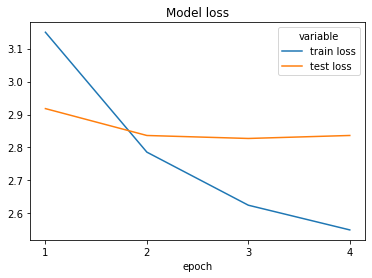

In [18]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

After training for three epochs and about 45 minutes, the validation loss is around 2.8273 and seems to be flattening out. I'm sure, with some longer training times and adaptation of the hyperparameters we could improve this further.

### Text generation

Let's see how our training results translate to the quality of text generation. Using the [pipelines](https://huggingface.co/transformers/main_classes/pipelines.html) class in transformers is straight forward for text generation:

In [19]:
# Restored Trained Model weights
# model.load_weights(PATH_BASE + "/data/models/2021-03-21_1925_GPT2-Model_03_2.8273.h5")

from transformers import pipeline

review = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

We call our `review` object using the token we defined for positive reviews as a prompt. Remember that we have trained our model to implicitly differentiate between positive and negative reviews using the appropriate tokens in the inputs. Consequently, the model hopefully learned to create reviews with different sentiments depending on the prompt we feed it. We wish to create outputs that are at most 150 tokens long, which should allow for mostly complete reviews (the model stops either when it generates an `<|endoftext|>` token or after `max_length` tokens) . Lastly, we ask for six different example reviews:

In [47]:
gen_pos = review("<|review_pos|>", max_length=150, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,"<|review_pos|> Habe mir bei meiner letzten Laserbehandlung mit dem Kryolipolyseverfahren die Augen lasern lassen . Es hat alles super geklappt ich hatte nach der Behandlung weder blaue Flecken , noch Pickelanfälle oder sonst irgendwelche Beschwerden !"
1,"<|review_pos|> Ich habe leider sehr schlechte Zähne in der Familie , das kann ich aus eigener Erfahrung nicht behaupten"
2,"<|review_pos|> Ich kann mich über die Praxis und die Behandlung sehr gut und kompetent informieren . Man bekommt auch am Wochenende Zeit für Notfälle , das Wartezimmer ist immer ansprechend und auch die Wartezeit ist sehr gering ."
3,"<|review_pos|> Ich war mit meiner Tochter in der Behandlung von Frau Dr . Brummel . Nach einer sehr ausführlichen Voruntersuchung wurde uns auf unsere Ängste und Sorgen sehr verständnis und kompetent und freundlich eingegangen . In einer Sitzung wurde mein Sohn zur Kontrolle gebeten . Hier fühlten wir uns mit allem gut aufgehoben . Vielen Dank dafür an Frau Dr . Brummel und ihr nettes Team , wir kommen gern wieder !"
4,"<|review_pos|> Ich war mit meinem Sohn 5 bei Dr . Zerhusen . Er hat sich Zeit genommen und ist auf all meine Fragen und Wünsche eingegangen . Meine Kinder waren noch sehr jung und hatten Schwierigkeiten , die Behandlung von Dr . Zerhusen zu beginnen . Wir fühlen uns mit unserem Sohn bei ihm sehr gut aufgehoben und können ihn aus vollem Herzen weiterempfehlen ."
5,"<|review_pos|> Bei Dr . Thiesing bin ich seit vielen Jahren in Behandlung , und bin absolut zufrieden , so wie von mir gewünscht . Sehr sehr sympathisch und kompetent , dabei immer freundlich und fürsorglich . Vorher hat alles bestens geklappt , und die neuen Ergebnisse freuen sich immer noch über jeden Besuch . Ich würde auch als junge Patientin in der Praxis weiter bleiben ."


I have to admit, I am super excited about the quality of those comments. Everything from grammar, to punctuation to spelling and even coherence seems natural with only few exceptions. I'm sure, most of these would easily pass as credible reviews! This really goes back to the fact that our data set is fantastic and we have a very well pre trained German GPT-2 to build upon.  
But what about negative reviews? We had way fewer of those in our training set. Was it enough to fine-tune our model for creating negative reviews as well? Let's check it out by creating reviews using a different prompt:

In [48]:
gen_neg = review("<|review_neg|>", max_length=150, num_return_sequences=6)
pd.DataFrame(gen_neg)

,generated_text
0,"<|review_neg|> Frau Dr . Wrensch wurde mir empfohlen . Sie wirkte auf mich ziemlich arrogant und unfreundlich . Ich habe mich nicht wohl bei ihr gefühlt . Als ich ihr meine Symptome schilderte , gab sie mir ein Rezept in die Hand und fragte mich daraufhin ob ich das Medikament nicht doch lieber nehme . Sie hat sich keine Zeit genommen und mich auch nicht weiter über mögliche Nebenwirkungen aufgeklärt . Auf meine Frage wurde ich unterbrochen ob sie mir nicht mal sagt , das wir das Medikament nehmen und nicht mit einer Packung ein Rezept aus der Apotheke zugeschickt werden . Ich werde nicht noch einmal hingehen ."
1,<|review_neg|> Ich hatte heute einen Termin und stand vor der verschlossenen Tür . Frau Dr . war pampig und unfreundlich .
2,"<|review_neg|> Dr . Heitkamp ist schon etwas älter . Er spricht auch nur mit einem über ein Kamm . Ich bin 20 Jahre alt und er hat mir in dem kurzen Zeitraum sehr geholfen . Es reicht ihm alles zu sagen , er ist ja jetzt da ."
3,"<|review_neg|> Ich hatte schon mehrmals den Eindruck , dass ich von Dr . Thum untersucht wurde und dass er auch mit mir und meinem Problem nicht ausreichend kommuniziert hat . Ich musste immer wieder Nachfragen zu Beschwerden und auch zu Unverträglichkeiten und was der Grund für meine Beschwerden sein könnte , bekam ich immer wieder die Antwort ich soll doch ins nächste Krankenhaus gehen , da mein Problem nicht besser wird . Ich bin mir sicher , dass man dies auch auf die Art und Weise erklären kann und trotzdem nimmt er sich keine Zeit und geht mit seinem Latein am Ende aus der Tür . Die Arzthelferinnen wirken schon manchmal gestresst und genervt . Allerdings gibt es eine sehr nette Kollegin mit was auch immer sie der Praxis etwas eigen ist ."
4,"<|review_neg|> Kann mich nur den vielen positiven Meinungen anschließen . Man bekommt relativ schnell einen Termin . Ist nicht gründlich , zieht einen auch vor wenn es um die Beschwerden geht . Die Untersuchung erfolgt unter Kurz und Überweisung ins Krankenhaus . Ich war lange Jahre Patientin in der Praxis und leider nicht zufrieden . Jetzt bin ich schwanger und fühle mich unwohl ."
5,<|review_neg|> Ich verstehe nur das es hier sehr viel zu wenig gute Ärzte gibt ! Man wird nicht Ernst genommen und auf die Beschwerden der Patienten wird gar nicht eingegangen ! Es war verlorene Zeit und Geldmacherei ! Die Arzthelferinnen sind nicht hilfsbereit !


First of all, each comment contains at least partly negative sentiments. So, training our model to differentiate between sentiments has been a success. However, my subjective feeling is that the quality is somewhat lower than before. While most of those are still pretty believable, coherence seems to have suffered a bit. Taking into account that we have only 49k negative examples in our data set, the result is still super fascinating!  
*Please note*: I have not redacted the outputs at all. Those were all first take results! Often times, when people post incredible results they are at least somewhat redacted. Usually, you let the model output multiple examples and manually choose the most appropriate ones. Thus, what we see here really is just a lower bound in terms of quality.

## Conclusion

We've learned how to fine-tune a pre trained German language GPT-2 model using the Transformers library and Tensorflow. For that, we've used a rich data set of German reviews of patients on their physicians. Leveraging the power of TPUs on Google Colab, we've trained the model on the task of causal language modeling. To do so, we provided work arounds to some quirks and undocumented pitfalls of the GPT-2 implementation. As a result, our model is able to generate human like, high quality text reviews. On top of that, it can be prompted to generate either positive or negative reviews.
<br>